# LIBS Analysis

In [1]:
# auto reload external packages
%load_ext autoreload
%autoreload 2

In [2]:
# import dependencies
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from plotly.offline import iplot, init_notebook_mode
import plotly.tools as tls
import plotly.graph_objs as go

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import seaborn as sns
import copy

init_notebook_mode(connected=True)

In [3]:
# raw_reading: single reading (corrupted or not, it is unknown)
# reading: subsampled or averaged multiple raw_readings - probably more noise free

# {BASEPATH}/{sample_path}/{raw_readings}.csv

# sample_path : one path of sample of soils (adana, samsun, etc.) - ex:{BASEPATH}/{labno}
# raw_reading_path : one path reading of one sample of soils (adana, samsun, etc.) - ex:{BASEPATH}/{labno}/{unix_rtime}.csv

BASEPATH = "samples"
LOCATIONS = ["adana", 'samsun', 'niğde', 'yozgat'] # adana, samsun, nigde, yozgat

MAX_NM = 604.
MIN_NM = 247.8
NUM_DATAPOINTS = 4096


TICK_PERIOD = (MAX_NM-MIN_NM)/NUM_DATAPOINTS
SAMPLE_PATHS = list(Path(BASEPATH).glob('*'))

In [4]:
# create and save .png file for all readings per sample
def subplot25(sample_readings_paths):
    fig, axes = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(30,10))
    for ix, sample_path in enumerate(sample_readings_paths):
        df = pd.read_csv(sample_path)
        ax = axes[ix//5,ix%5]
        ax.plot(df['wavelengths'], df['intensities'], )
        ax.set_title(sample_path.name)
    fig.suptitle(sample_path.parent.name)
    image_save_path = sample_path.parent
    plt.savefig(image_save_path / 'readings.png')
    
    
# Call it
# for sample_path in SAMPLE_PATHS:
#     raw_reading_paths = Path(sample_path).glob('*.csv') # filter csv files
#     # show and save figures
#     subplot25(raw_reading_paths)

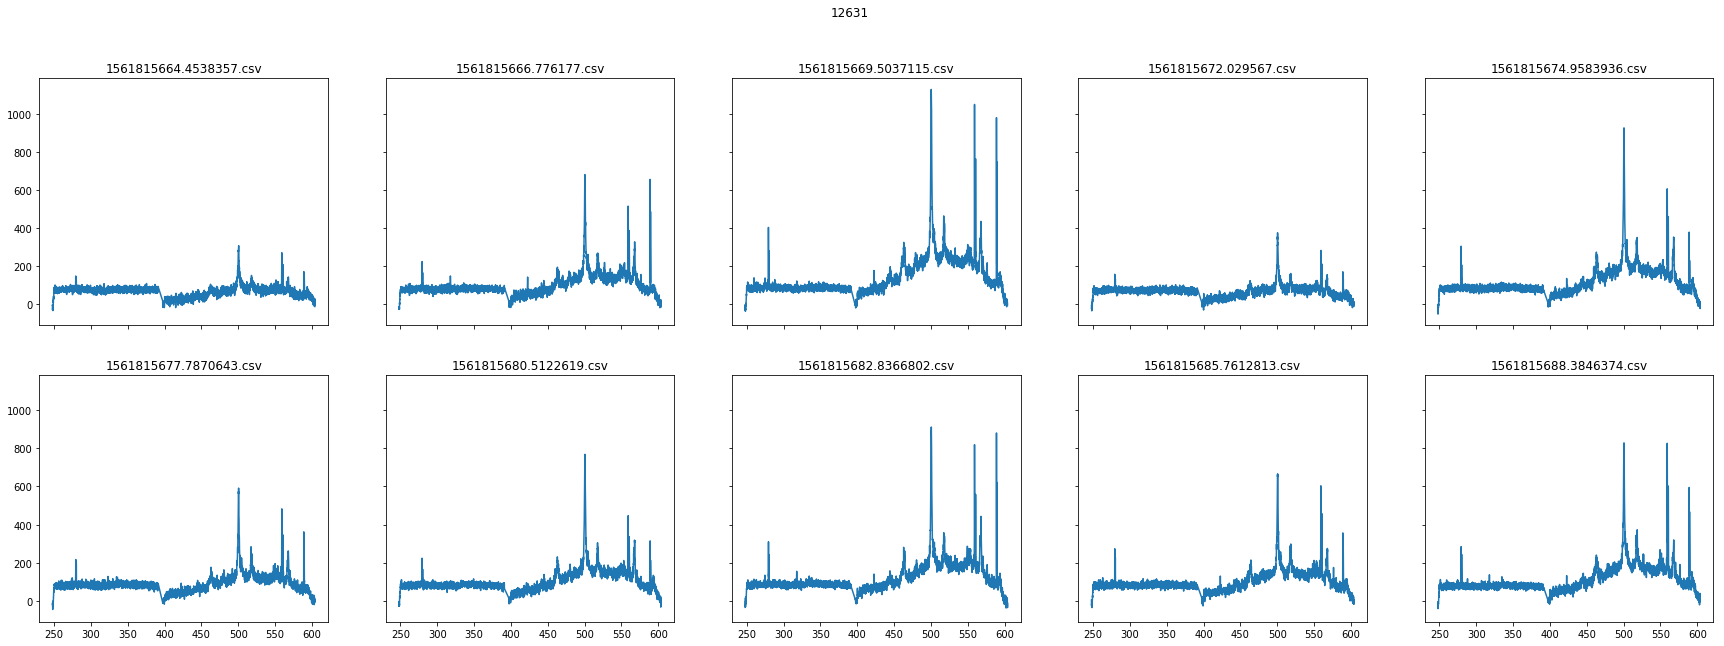

In [5]:
# 1 Sample of subplot25
raw_reading_paths = Path(SAMPLE_PATHS[0]).glob('*.csv')
subplot25(raw_reading_paths)

In [6]:
from functools import partial
from scipy import signal

class Sample:
    def __init__(self, sample_path):
        self.raw_readings = [pd.read_csv(raw_reading_path) 
                             for raw_reading_path in Path(sample_path).glob('*.csv')]
        
        # average samples
        self.reading = self.dataframes_average(self.raw_readings)

        # downsample
        self.reading = self.reading.rolling(window=11, center=True, min_periods=5).max() # window=11 equals 1nm
        
        # round sample
        self.reading = self.reading.round(3)
        
        self.plot = partial(self.subplot, [self.reading], 1, 1)
        
        self.reading = self.find_peaks(self.reading)
        self.sample_path = sample_path
        self.labno = int(sample_path.name)
        
    
    @staticmethod
    def find_peaks(reading, inplace=False):
        if not inplace:
            reading = reading.copy()
        
        peak_interval = 1.
        wavelengths = reading['wavelengths'].values
        intensities = reading['intensities'].values
        
        wavelengths_range = wavelengths.max() - wavelengths.min()
        sampling_interval = wavelengths_range / wavelengths.shape[0]

        peak_ixs = signal.argrelmax(intensities,
                                    order=int(peak_interval / sampling_interval))[0]
        
        reading['is_peak'] = False
        reading.loc[peak_ixs, 'is_peak'] = True
        return reading
    
    @staticmethod
    def get_reading_cond(intensities_above=200, is_peak=True):
        return s.reading.loc[(s.reading['intensities'] > intensities_above) & (s.reading['is_peak']==is_peak)]
        
        
    @staticmethod
    def subplot(readings, row, col):
        fig, axes = plt.subplots(row, col, sharex=True, sharey=True, squeeze=False)
        for ix, reading in enumerate(readings):
            axes[ix//col,ix%col if col!=1 else 0].plot(reading['wavelengths'], reading['intensities'])

    @staticmethod
    def plotly_plot(s):
        peak_df = s.reading.loc[s.reading['is_peak'] == True, :]
        trace_reading = go.Scatter(x=s.reading['wavelengths'], y=s.reading['intensities'], name='reading')
        trace_peak = go.Scatter(x=peak_df['wavelengths'], y=peak_df['intensities'], mode='markers', name='peaks')
        layout = go.Layout(
            xaxis=dict(
                range=[200, 700]
            ),
            yaxis=dict(
                range=[0, 2000]
            )
        )
        fig = go.Figure(data=[trace_reading, trace_peak], layout=layout)
        return fig
    
    
#     @staticmethod
#     def dataframes_round(dataframes):
#         r_dataframes = []
#         for df in dataframes:
#             r_dataframes += [df.round(2)]
#         return r_dataframes
    
    @staticmethod
    def dataframes_average(dataframes):
        avg_df = dataframes[0].copy()
        for df in dataframes[1:]:
            avg_df += df
        return avg_df / dataframes.__len__()
    
    def get_intensity_at(self, nm, error_margin=0.):
        intensities = self.reading.loc[(nm-error_margin < self.reading['wavelengths']) & 
                                (self.reading['wavelengths'] < nm+error_margin), 'intensities'].values
        if(intensities.shape[0] > 1):
            print(f'More than 1 intensities returned at {nm} +- {error_margin}')
        return intensities[0]

    def get_nearest_nm(self, nm, error_margin=0.):
        wavelengths = self.reading.loc[(nm-error_margin < self.reading['wavelengths']) & 
                            (self.reading['wavelengths'] < nm+error_margin), 'wavelengths'].values
        if(wavelengths.shape[0] > 1):
            print(f'More than 1 wavelengths returned at {nm} +- {error_margin}')
        return wavelengths[0]
    
    def is_peak_at(self, nm):
        return self.reading.loc[self.reading['wavelengths'] == nm, 'is_peak'].values[0] == True

        


# Azotu tekrarlananlar

In [7]:
# SAMPLES = {sample_path.name:Sample(sample_path) for sample_path in SAMPLE_PATHS}

In [8]:
N_nms = [279.482,
         334.762,
         421.624,
         [443.506, 443.613],
         498.2, 
         498.9,
         [499.9, 500.540],         
         501.6, 
         503.0,
         [589.024, 589.116]]

# 742.36 nm,
# 744,23
# 746,83



class Analysis:
    def __init__(self, sample_paths, locations, excel_path="Azotu tekrarlananlar.xlsx"):
        self.locations = locations
        
        self.excel = pd.read_excel(excel_path)
        self.excel = self.excel.loc[self.excel['Valid']==1, :] # get only valid samples
        self.data = self.excel.loc[self.excel['Loc'].str.lower().isin(self.locations)].iloc[:, :5] # get location only && first 5 column
        
        self.samples = {sample_path.name:Sample(sample_path) for sample_path in sample_paths}
        
        
        
        self.data = self.create_nm_columns(self.data.copy())
        self.data = self.insert_peak_values(self.data.copy(), self.samples)
        
        
        self.data = self.data.sort_values(by=['%Azot'])
        
    
    def plot(self):
        plot_df = self.data
        cols = plot_df.columns.values[5:]
                 
        data = [go.Scatter(x=plot_df['%Azot'], y=plot_df[col], 
                            name=col, mode='lines+markers') for col in cols]
  
        layout = go.Layout()
        fig = go.Figure(data=data)
        iplot(fig)
        
    def heatmap(self, x_col, y_col):
        plot_df = self.data.copy()
                 
        data = [go.Heatmap(x=plot_df[x_col], 
                           y=plot_df[y_col], 
                           z=plot_df['%Azot'], zsmooth='best', colorscale='viridis')]
  
        layout = go.Layout()
        fig = go.Figure(data=data)
        iplot(fig)
        
    def apply_PCA(self, n_components=3):
        feature_cols = self.data.columns[5:]
        data_subset = self.data[feature_cols].values
        pca = PCA(n_components=n_components)
        pca_result = pca.fit_transform(data_subset)
        
        pca_df = self.data.copy()
        pca_df['pca-one'] = pca_result[:,0]
        pca_df['pca-two'] = pca_result[:,1] 
        if n_components > 2:
            pca_df['pca-three'] = pca_result[:,2]
        print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
        
        
        plt.figure(figsize=(8,6))
        sns.scatterplot(
            x="pca-one", y="pca-two",
            hue="%Azot",
            palette=sns.color_palette("hls", 10),
            data=pca_df,
            legend="full",
            alpha=0.8
        )
        
        return pca_df
    
    def apply_tSNE(self, n_components=2):
        
        feature_cols = self.data.columns[5:]
        data_subset = self.data[feature_cols].values
        tsne = TSNE(n_components=n_components, verbose=1, perplexity=40, n_iter=300)
        tsne_results = tsne.fit_transform(data_subset)
        
        tsne_df = self.data.copy()
        tsne_df['tsne-2d-one'] = tsne_results[:,0]
        tsne_df['tsne-2d-two'] = tsne_results[:,1]
        
        plt.figure(figsize=(8,6))
        sns.scatterplot(
            x="tsne-2d-one", y="tsne-2d-two",
            hue="%Azot",
            palette=sns.color_palette("hls", 10),
            data=tsne_df,
            legend="full",
            alpha=0.8
        )
        
        return tsne_df
        
        
        
    def get_by_labno(self, labno, query='%Azot'):
        return self.data.loc[self.data['Lab no'] == labno, query].values[0]
    
    @staticmethod
    def create_nm_columns(df):
        for i, N_nm in enumerate(N_nms):
            peak_str = ''
            if isinstance(N_nm, (list,)):
                peak_str = '-'.join([f'N{i}@{eachnm}' for eachnm in N_nm])
            else:
                peak_str += f'N{i}@{N_nm}'

            df[peak_str] = np.nan
        return df

    @staticmethod
    def insert_peak_values(df, samples):
        for labno, sample in samples.items():
            for i, N_nm in enumerate(N_nms):
                peak_str = ''
                peak_value = 0.
                if isinstance(N_nm, (list,)):
                    peak_str = '-'.join([f'N{i}@{eachnm}' for eachnm in N_nm])
                    peak_value = max([sample.get_intensity_at(eachnm, TICK_PERIOD/2) for eachnm in N_nm])
                else:
                    peak_str += f'N{i}@{N_nm}'
    #                 print(N_nm, sample.labno)
                    peak_value = sample.get_intensity_at(N_nm, TICK_PERIOD/2)

                df.loc[df['Lab no']==sample.labno, peak_str] = peak_value
        return df
        

In [9]:
analysis = Analysis(sample_paths=SAMPLE_PATHS, locations=LOCATIONS)

In [14]:
analysis.data.head(n=10)

,Lab no,Loc,SampleNo,Valid,%Azot,N0@279.482,N1@334.762,N2@421.624,N3@443.506-N3@443.613,N4@498.2,N5@498.9,N6@499.9-N6@500.54,N7@501.6,N8@503.0,N9@589.024-N9@589.116
1,2388,Samsun,19,1,0.06,233.816,86.494,43.425,85.054,177.414,213.528,549.653,549.653,238.343,397.760
58,13070,Adana,45,1,0.06,239.575,89.771,47.445,104.003,174.714,215.569,550.083,550.083,240.762,242.152
69,14136,Niğde,15,1,0.11,195.292,95.847,61.375,102.276,242.378,313.892,787.574,787.574,342.427,389.558
62,14110,Niğde,10,1,0.11,164.206,91.968,60.265,97.199,238.702,307.879,827.208,827.208,330.442,372.487
52,13047,Adana,46,1,0.11,176.078,81.930,37.545,78.502,146.221,184.708,455.168,455.168,204.752,259.805
54,13053,Adana,29,1,0.16,184.044,83.770,31.198,56.510,122.773,157.980,393.234,393.234,173.213,182.200
25,2419,Samsun,50,1,0.17,191.403,88.874,43.963,70.180,153.292,189.900,475.767,473.755,214.955,375.701
26,3611,Yozgat,16,1,0.17,211.228,83.977,37.175,72.809,148.526,176.714,437.392,437.392,189.486,373.715
61,14109,Niğde,18,1,0.17,189.820,91.724,57.112,98.257,223.615,277.588,744.903,725.651,312.207,418.484
34,3633,Yozgat,24,1,0.17,186.236,83.503,31.652,53.818,123.340,145.984,344.600,344.600,155.465,251.893


In [15]:
Sample.plotly_plot(analysis.samples['3623']).show()

# s = analysis.samples['2388']

# s.reading

# peak_interval = 1.
# wavelengths = s.reading['wavelengths'].values
# intensities = s.reading['intensities'].values

# wavelengths_range = wavelengths.max() - wavelengths.min()
# sampling_interval = wavelengths_range / wavelengths.shape[0]

# peak_ixs = signal.argrelmax(intensities,
#                             order=int(peak_interval / sampling_interval))[0]

In [12]:
signal.argrelmax(intensities)

NameError: name 'intensities' is not defined

In [13]:
pca_df = analysis.apply_PCA(n_components=5)

Explained variation per principal component: [9.06753001e-01 8.17874163e-02 9.20251017e-03 1.03502218e-03
 5.24775596e-04]


ValueError: The palette list has the wrong number of colors.

<Figure size 576x432 with 0 Axes>

In [ ]:
tsne_df = analysis.apply_tSNE(n_components=2)

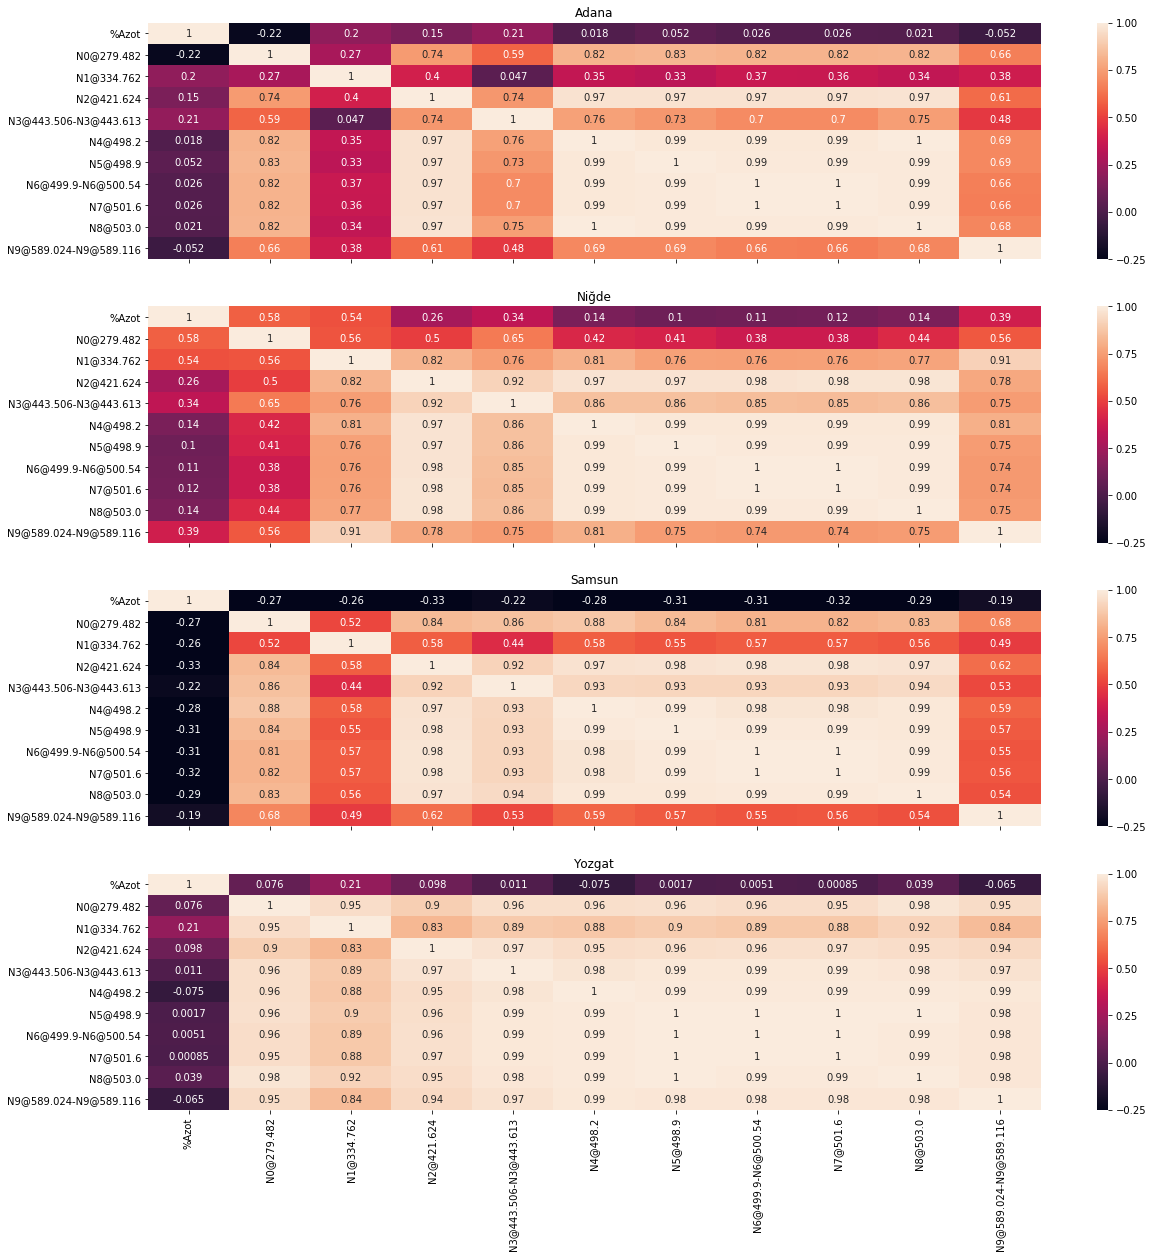

In [16]:
fig, ax = plt.subplots(4,1, figsize=(20,20), sharex=True)

for i, (loc,data) in enumerate(analysis.data.groupby(by='Loc')):
    sns.heatmap(data.drop(['Lab no', 'Valid'], axis=1).corr(), annot=True, ax=ax[i], vmin=-0.25, vmax=1.0)
    ax[i].title.set_text(loc)

plt.savefig('corr.png')

In [41]:
corr = analysis.data.drop(['Valid'], axis=1).corr()
corr.style.background_gradient(cmap='coolwarm')

,Lab no,%Azot,N0@279.482,N1@334.762,N2@421.624,N3@443.506-N3@443.613,N4@498.2,N5@498.9,N6@499.9-N6@500.54,N7@501.6,N8@503.0,N9@589.024-N9@589.116
Lab no,1,-0.137967,-0.0319788,0.0982297,0.357861,0.464234,0.334233,0.380497,0.394955,0.391099,0.380706,-0.132047
%Azot,-0.137967,1,-0.0707087,0.0904796,-0.0334117,0.00148527,-0.0949182,-0.102592,-0.10726,-0.106211,-0.0927112,0.0249783
N0@279.482,-0.0319788,-0.0707087,1,0.590381,0.668814,0.67647,0.652337,0.629829,0.616524,0.617454,0.641476,0.649211
N1@334.762,0.0982297,0.0904796,0.590381,1,0.740774,0.590827,0.743563,0.715141,0.716908,0.717194,0.726826,0.75255
N2@421.624,0.357861,-0.0334117,0.668814,0.740774,1,0.893863,0.968327,0.971752,0.973718,0.974394,0.973613,0.695962
N3@443.506-N3@443.613,0.464234,0.00148527,0.67647,0.590827,0.893863,1,0.86891,0.872084,0.871232,0.869853,0.884193,0.553807
N4@498.2,0.334233,-0.0949182,0.652337,0.743563,0.968327,0.86891,1,0.991832,0.988585,0.988286,0.991509,0.732066
N5@498.9,0.380497,-0.102592,0.629829,0.715141,0.971752,0.872084,0.991832,1,0.99636,0.996352,0.994548,0.682284
N6@499.9-N6@500.54,0.394955,-0.10726,0.616524,0.716908,0.973718,0.871232,0.988585,0.99636,1,0.999751,0.995351,0.668809
N7@501.6,0.391099,-0.106211,0.617454,0.717194,0.974394,0.869853,0.988286,0.996352,0.999751,1,0.994997,0.66947


In [38]:
def label_vs_predicted_plot(model, analysis):
    features = analysis.data.iloc[:50, 5:].values
    labels = analysis.data['%Azot'].iloc[:50].values
    model.fit(features, labels)
    
    test_features = analysis.data.iloc[50:, 5:].values
    test_labels = analysis.data['%Azot'].iloc[50:].values
    predicted = model.predict(test_features)
    print(model.score(test_features, test_labels))

    f, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlabel('labels')
    ax.set_ylabel('predicted')
    ax.plot(test_labels, predicted, '.')
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--")

-2.9407945793789394


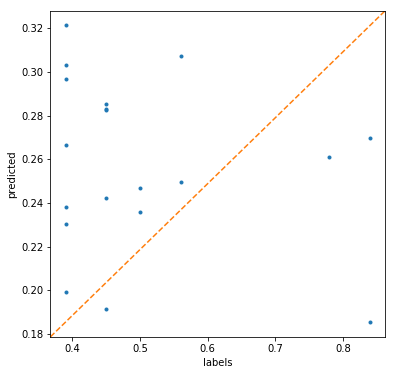

In [39]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
label_vs_predicted_plot(model, analysis)


-3.4942271685490427


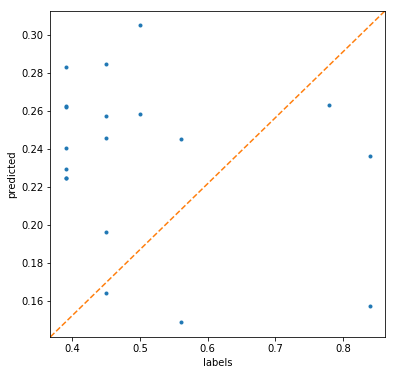

In [40]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100)
label_vs_predicted_plot(model, analysis)

In [26]:
analysis.data.iloc[:, :].head()

,Lab no,Loc,SampleNo,Valid,%Azot,N0@279.482,N1@334.762,N2@421.624,N3@443.506-N3@443.613,N4@498.2,N5@498.9,N6@499.9-N6@500.54,N7@501.6,N8@503.0,N9@589.024-N9@589.116
1,2388,Samsun,19,1,0.06,233.816,86.494,43.425,85.054,177.414,213.528,549.653,549.653,238.343,397.760
58,13070,Adana,45,1,0.06,239.575,89.771,47.445,104.003,174.714,215.569,550.083,550.083,240.762,242.152
69,14136,Niğde,15,1,0.11,195.292,95.847,61.375,102.276,242.378,313.892,787.574,787.574,342.427,389.558
62,14110,Niğde,10,1,0.11,164.206,91.968,60.265,97.199,238.702,307.879,827.208,827.208,330.442,372.487
52,13047,Adana,46,1,0.11,176.078,81.930,37.545,78.502,146.221,184.708,455.168,455.168,204.752,259.805


In [36]:
analysis.data.shape

(69, 15)

In [37]:
analysis.data.tail()

,Lab no,Loc,SampleNo,Valid,%Azot,N0@279.482,N1@334.762,N2@421.624,N3@443.506-N3@443.613,N4@498.2,N5@498.9,N6@499.9-N6@500.54,N7@501.6,N8@503.0,N9@589.024-N9@589.116
9,2396,Samsun,27,1,0.56,246.240,93.708,41.410,85.311,170.955,188.741,463.720,463.720,216.271,439.570
16,2410,Samsun,41,1,0.56,140.623,84.827,18.793,46.083,92.691,97.533,206.507,201.673,107.949,314.380
66,14124,Niğde,11,1,0.78,230.398,107.944,74.806,127.185,266.605,342.546,882.157,882.157,369.713,608.690
43,12643,Adana,37,1,0.84,189.430,88.137,52.732,101.226,178.698,236.338,601.435,601.435,251.900,212.596
38,12636,Adana,41,1,0.84,155.470,84.883,30.110,86.446,107.373,136.354,305.035,301.507,146.822,169.450
